In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [12]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [44]:
# Import Lab
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy import optimize, stats                     
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from keras.utils import np_utils

data source :[ find it here ](#https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

shortcut: kaggle competitions download -c competitive-data-science-predict-future-sales

In [63]:
df_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
df_shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
df_items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
df_item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [17]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [18]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [19]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [20]:
df_test.isna().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [22]:
import pandas_profiling as autoprofiling
#autoprofiling.ProfileReport(df_train)



### Data Description
#### File descriptions

    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    sample_submission.csv - a sample submission file in the correct format.
    items.csv - supplemental information about the items/products.
    item_categories.csv - supplemental information about the items categories.
    shops.csv- supplemental information about the shops.

####  Data fields

    ID - an Id that represents a (Shop, Item) tuple within the test set
    shop_id - unique identifier of a shop
    item_id - unique identifier of a product
    item_category_id - unique identifier of item category
    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    item_price - current price of an item
    date - date in format dd/mm/yyyy
    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    item_name - name of item
    shop_name - name of shop
    item_category_name - name of item category


In [64]:
df_train.drop(['date_block_num','item_price'], axis=1, inplace=True) ## date_block_num

In [24]:
df_train.head()

,date,shop_id,item_id,item_cnt_day
0,02.01.2013,59,22154,1.0
1,03.01.2013,25,2552,1.0
2,05.01.2013,25,2552,-1.0
3,06.01.2013,25,2554,1.0
4,15.01.2013,25,2555,1.0


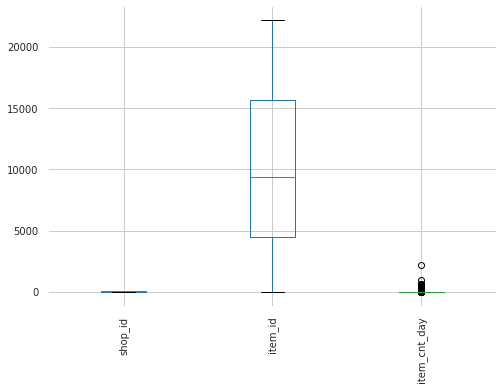

In [52]:
numerical_columns = df_train[["shop_id", "item_id", "item_cnt_day"]]
# checking for outliers numerical columns
numerical_columns.boxplot(showcaps=True, showfliers=True)
plt.xticks(rotation=90);


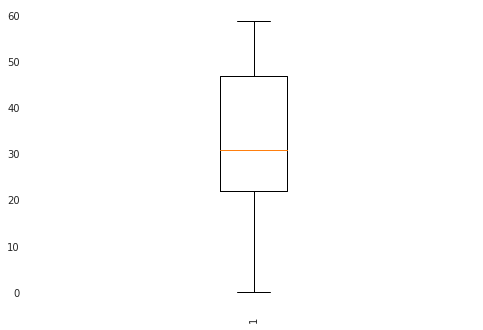

In [50]:

plt.boxplot(df_train["shop_id"], showcaps=True, showfliers=True)
plt.xticks(rotation=90);

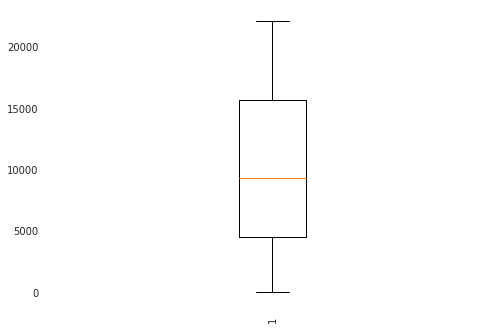

In [51]:
plt.boxplot(df_train["item_id"], showcaps=True, showfliers=True)
plt.xticks(rotation=90);

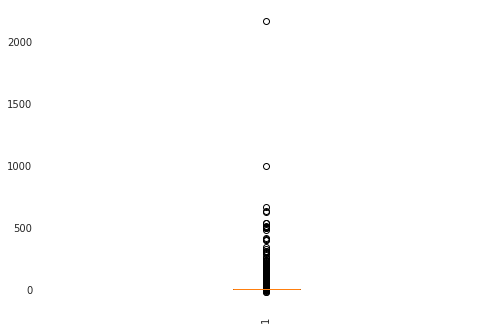

In [53]:
#item_cnt_day --> not so useful
plt.boxplot(df_train["item_cnt_day"], showcaps=True, showfliers=True)
plt.xticks(rotation=90);

In [65]:
## we need only month wise predictions,so removing date in dates

df_train['date'] = pd.to_datetime(df_train['date'], dayfirst=True)
df_train['date'] = df_train['date'].apply(lambda x: x.strftime('%Y-%m'))
df_train.head()


,date,shop_id,item_id,item_cnt_day
0,2013-01,59,22154,1.0
1,2013-01,25,2552,1.0
2,2013-01,25,2552,-1.0
3,2013-01,25,2554,1.0
4,2013-01,25,2555,1.0


In [33]:
len(df_train['date'].unique()) #-->34
len(df_train['shop_id'].unique())  # --> 60
len(df_train['item_id'].unique())  #--> 21807

21807

In [66]:
# grouping based on date and then shop_id and then Item_id..
df = df_train.groupby(['date','shop_id','item_id']).sum()
df = df.pivot_table(index=['shop_id','item_id'], columns='date', values='item_cnt_day', fill_value=0)
df.reset_index(inplace=True)
df.head().T


,0,1,2,3,4
date,,,,,
shop_id,0,0,0,0,0
item_id,30,31,32,33,35
2013-01,0,0,6,3,1
2013-02,31,11,10,3,14
2013-03,0,0,0,0,0
2013-04,0,0,0,0,0
2013-05,0,0,0,0,0
2013-06,0,0,0,0,0
2013-07,0,0,0,0,0


In [67]:
# merging test_dataset
df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
df_test.drop(['ID', '2013-01'], axis=1, inplace=True) #to reduce the shape
df_test = df_test.fillna(0)
df_test.head().T

,0,1,2,3,4
shop_id,5.0,5.0,5.0,5.0,5.0
item_id,5037.0,5320.0,5233.0,5232.0,5268.0
2013-02,0.0,0.0,0.0,0.0,0.0
2013-03,0.0,0.0,0.0,0.0,0.0
2013-04,0.0,0.0,0.0,0.0,0.0
2013-05,0.0,0.0,0.0,0.0,0.0
2013-06,0.0,0.0,0.0,0.0,0.0
2013-07,0.0,0.0,0.0,0.0,0.0
2013-08,0.0,0.0,0.0,0.0,0.0
2013-09,0.0,0.0,0.0,0.0,0.0


In [68]:
# split into train and test sets
Y_train = df['2015-10'].values
X_train = df.drop(['2015-10'], axis = 1) #2015-10
X_test = df_test

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(424124, 35) (424124,)
(214200, 35)


In [38]:
x_train, x_test, y_train, y_test = train_test_split( X_train, Y_train, test_size=0.20, random_state=1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(339299, 35)
(84825, 35)
(339299,)
(84825,)


In [39]:
y_test

array([0, 0, 0, ..., 0, 0, 3])

In [40]:
%time
LR = LinearRegression()
LR.fit(x_train,y_train)

print('Train set mse:', mean_squared_error(y_train, LR.predict(x_train)))
print('Test set mse:', mean_squared_error(y_test, LR.predict(x_test)))
print('Test set score:', LR.score(x_train,y_train))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 15.5 µs
Train set mse: 11.035196010127327
Test set mse: 5.2168072544203135
Test set score: 0.4383032716523845


In [45]:
start = timeit.timeit()

RFR = RandomForestRegressor(n_estimators = 100)
RFR.fit(x_train,y_train)

print('Train set mse:', mean_squared_error(y_train, RFR.predict(x_train)))
print('Test set mse:', mean_squared_error(y_test, RFR.predict(x_test)))
print('Test set score:', RFR.score(x_train,y_train))
end = timeit.timeit()
print(end - start)

Train set mse: 3.471271265756751
Test set mse: 0.8139259487179489
Test set score: 0.8233106406634497
0.0008097699992504204


In [46]:
start = timeit.timeit()

XGB = XGBRegressor(max_depth=16,n_estimators=200,seed=1)
XGB.fit(x_train,y_train)

print('Train set mse:', mean_squared_error(y_train, XGB.predict(x_train)))
print('Test set mse:', mean_squared_error(y_test, XGB.predict(x_test)))
print('Test set score:', XGB.score(x_train,y_train))

end = timeit.timeit()
print(end - start)

Train set mse: 0.01816715629513515
Test set mse: 0.893909188595394
Test set score: 0.9990752830991863
0.013875900999664736


In [47]:
start = timeit.timeit()

LGBM = LGBMRegressor(max_depth=16,n_estimators=200,seed=1)
LGBM.fit(x_train,y_train)

print('Train set mse:', mean_squared_error(y_train, LGBM.predict(x_train)))
print('Test set mse:', mean_squared_error(y_test, LGBM.predict(x_test)))
print('Test set score:', LGBM.score(x_train,y_train))

end = timeit.timeit()
print(end - start)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Train set mse: 5.777594430345526
Test set mse: 4.355020568961951
Test set score: 0.7059176940521745
-0.002268950000143377


In [69]:
prediction = RFR.predict(X_test)


In [70]:
prediction = list(map(round, prediction))

In [71]:
len(prediction)

214200

In [72]:
df_submission = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
df_submission['item_cnt_month'] = prediction
df_submission.to_csv('submission_1.csv', index=False)
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   ID              214200 non-null  int64
 1   item_cnt_month  214200 non-null  int64
dtypes: int64(2)
memory usage: 3.3 MB


In [73]:
df_submission.to_csv("./submission.csv")